## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [28]:
import numpy as np
import pandas as pd

emails = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = emails['Email Text'].str.split()
tokens.head()

0    [re, :, 6, ., 1100, ,, disc, :, uniformitarian...
1    [the, other, side, of, *, galicismos, *, *, ga...
2    [re, :, equistar, deal, tickets, are, you, sti...
3    [Hello, I, am, your, hot, lil, horny, toy., I,...
4    [software, at, incredibly, low, prices, (, 86,...
Name: Email Text, dtype: object

In order to clean the tokens, I would take out words that don't really indicate spam and instead are just common words used in sentences like 'the' or 'and'. After narrowing it down, I would then one-hot encoded the tokens so that they each have a corresponding binary value. This way, it can be easier to run the PCA. I would use PCA as my predictive algorithm because it would be the best way to identify the tokens that are most associated with scam or spam emails.

### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [ ]:
import pickle
from collections import Counter

with open('/Users/borayadiul/labs/05_PCA/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

count    48691.000000
mean         5.687889
std         27.717476
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1365.000000
Name: count, dtype: float64

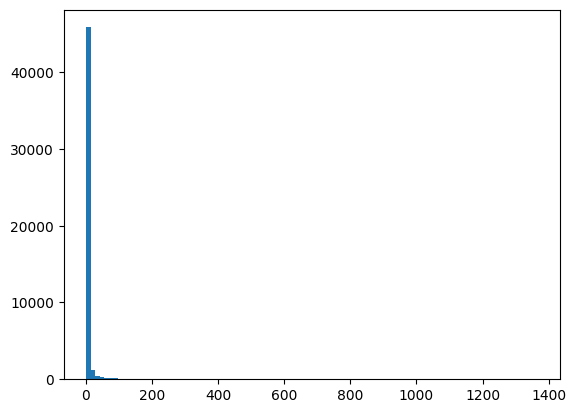

In [25]:
graph1 = pd.DataFrame(token_freq,columns=['token','count'])
graph1['count'].hist(grid=False,bins=100)
graph1['count'].describe()

It seems that there is a high amount of tokens that are closer to 0-5. The histogram has a long tail and right skewed. Looking at the describe table, it seems that the highest occurance of a token is 1365 times. Since most of the tokens only occur a few times, it can be harder to identify which ones are most indicative of a spam or scam email.

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [35]:
emails_clean = pd.read_parquet('/Users/borayadiul/labs/05_PCA/Phishing_clean.parquet')
Y1 = emails_clean['Email Type']
X1 = emails_clean.drop('Email Type',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.2, random_state=125)

lm1 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm1.predict(X_test)
y_hat_train_0 = lm1.predict(X_train)
print('The R2 for train is: ', r2_score(y_hat_train_0,y_train) )
print('The R2 for test is: ', r2_score(y_hat_test_0,y_test) )

The R2 for train is:  0.6198108844663195
The R2 for test is:  -0.00026838432720110994


The r2 for the training set is relatively high, indicating that is a good fit. Conversely, the test set had a r2 value that is very low and negative. This indicates that this set is poorly fit. 

In [42]:
coef1 = pd.DataFrame({'variable':lm1.feature_names_in_ , 'value':lm1.coef_})
coef1['abs'] = np.abs(coef1['value'])
coef1.sort_values('abs',ascending=False)

,variable,value,abs
72,1998,-1.719764e+13,1.719764e+13
33,2001,-1.478868e+13,1.478868e+13
470,2004,1.204847e+13,1.204847e+13
6,2002,8.974490e+12,8.974490e+12
1380,wysak,8.492733e+12,8.492733e+12
...,...,...,...
233,wanted,-5.340576e-05,5.340576e-05
1234,worldwide,-4.577637e-05,4.577637e-05
845,murphy,-4.577637e-05,4.577637e-05
2558,"09,",1.618481e-06,1.618481e-06


Looking at the table, it seems that the words with the largest coefficients are actually numbers such as 1998, 2001, etc. This means that these number values are strongly influencing the predictions.

### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

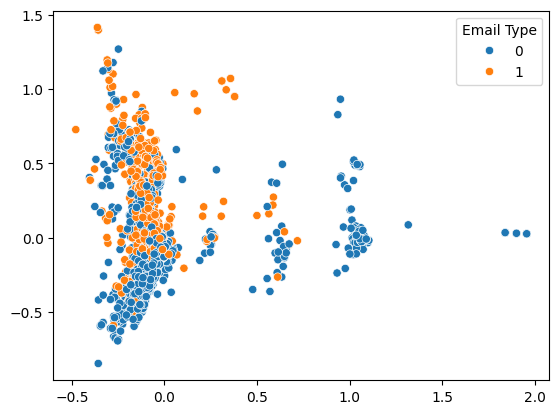

In [36]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

Looking at the orange points that indicate the scams, it seems that they have lower first components but higher second components with the PCA. Conversly, the blue dots seem relatively spread out.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [38]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('The R2 for train is: ', r2_score(y_hat_train,y_train) )
print('The R2 for test is: ', r2_score(y_hat_test,y_test) ) 

The R2 for train is:  0.6928975360963749
The R2 for test is:  0.587390597321718


These R squared values are better than the linear regression. The R sqaured values for the training set are still high and higher than before, indicating a good fit. Addtionally, the R-squared values for the test set are much better, at .587 instead of -.000 =. This indicates a better fit for this analysis.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Principal components allow for the analysis of the features within data in a manner that is independent from the other features. This makes it easier to make clear conclusions. Addtionally, it allows for an easier way to account for how many components to include, making it easier for us to curate the analysis in a manner that reflects what we are seeking to look at or predict with the data at hand.